IMPORT LIBRARIES

In [2]:
from operator import concat

import kagglehub
import kagglehub.config
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DOWNLOAD DATASET

we are using deepglobe-road-extraction-dataset from kaggle  
https://www.kaggle.com/datasets/payne18/road-detection-dataset-with-masks  
The dataset is already split into train, validation and test, but validation and test data does not have masks. We didn't want to manually annotate the validation and test data, so we only use the train dataset.


In [3]:
# get kaggle.json file form ./volume/kaggle.json
with open("./data/kaggle.json", "r") as f:
    kaggle_json = json.load(f)
kaggel_username = kaggle_json["username"]
kaggel_key = kaggle_json["key"]

In [4]:
kagglehub.config.set_kaggle_credentials(kaggel_username, kaggel_key)

Kaggle credentials set.


In [16]:
# Download latest version
path = kagglehub.dataset_download("payne18/road-detection-dataset-with-masks")


Resuming download from 312475648 bytes (3775254070 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/payne18/road-detection-dataset-with-masks?dataset_version_number=1 (312475648/4087729718) bytes left.


100%|██████████| 3.81G/3.81G [02:15<00:00, 28.0MB/s]


Extracting files...


In [18]:
# Move data folder to ./data
os.system(f"mv {path} ./data/road-detection-dataset-with-masks")

0

LOAD DATA

In [5]:
data_path = os.path.abspath("./data/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset")
metadata_path = "./data/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset/metadata.csv"

In [6]:
#open metadata
metadata = pd.read_csv(metadata_path)
print(f"All data: {metadata.shape[0]}")
metadata.head()

All data: 8570


,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


In [7]:
# delete rows where split is not train
metadata = metadata[metadata["split"] == "train"]
print(f"Data withouth validation and test: {metadata.shape[0]}")
metadata.head()

Data withouth validation and test: 6226


,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


In [8]:
# extend paths to full path
metadata["sat_image_path"] = metadata["sat_image_path"].apply(lambda x: os.path.join(data_path, x))
metadata["mask_path"] = metadata["mask_path"].apply(lambda x: os.path.join(data_path, x))
metadata.head()

,image_id,split,sat_image_path,mask_path
0,100034,train,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...
1,100081,train,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...
2,100129,train,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...
3,100703,train,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...
4,100712,train,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...


VISUALIZE DATA

In [9]:
# select 4 random images
random_index = np.random.randint(0, metadata.shape[0], 4)
images = [cv2.imread(metadata.iloc[i]["sat_image_path"]) for i in random_index]
masks = [cv2.imread(metadata.iloc[i]["mask_path"]) for i in random_index]

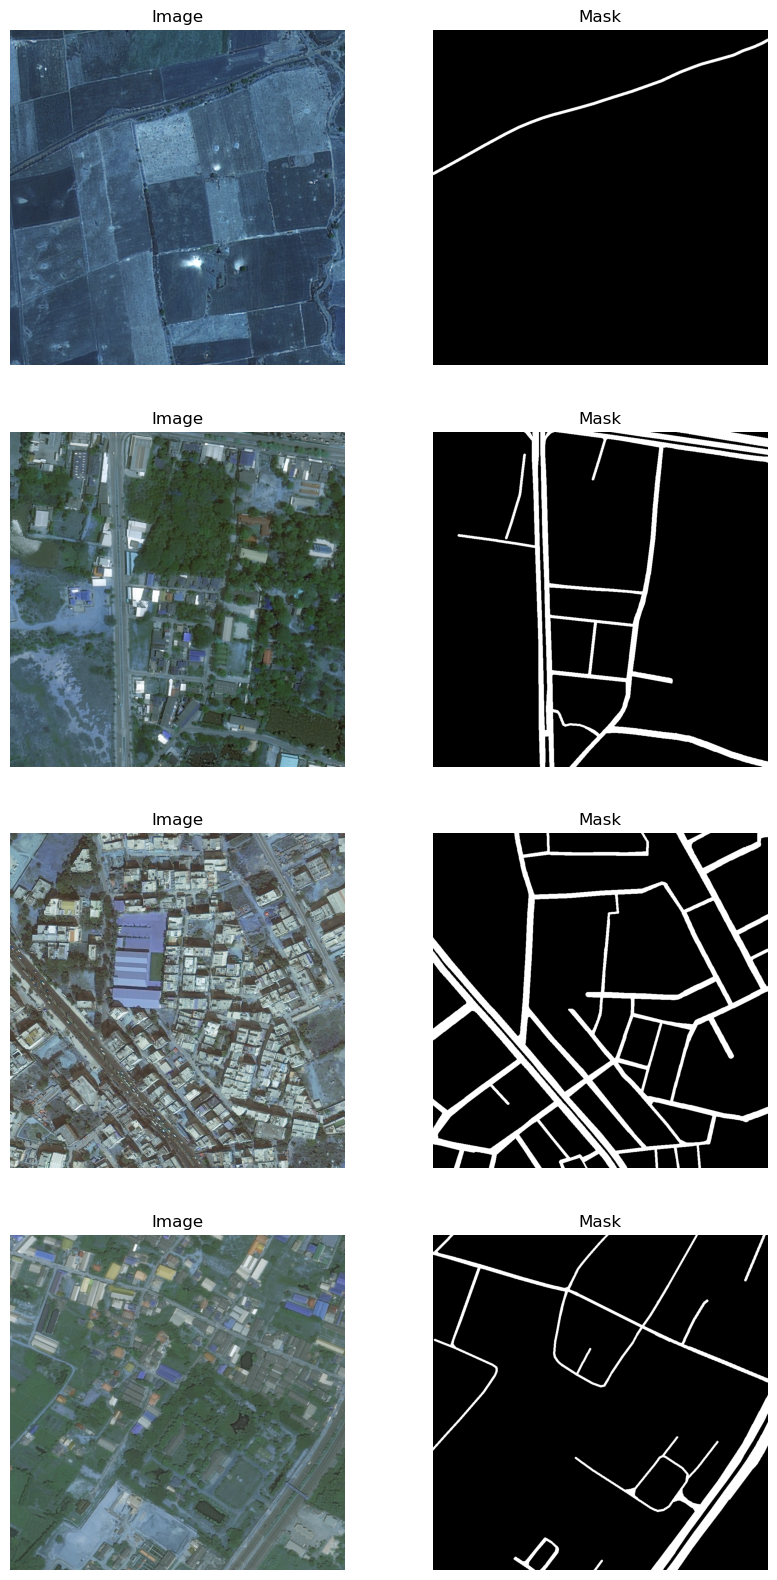

In [10]:
# Plot images and masks
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
for i in range(4):
    axs[i, 0].imshow(images[i])
    axs[i, 0].title.set_text("Image")
    axs[i, 1].imshow(masks[i])
    axs[i, 1].title.set_text("Mask")
    axs[i, 0].axis("off")
    axs[i, 1].axis("off")
plt.show()


TODO
- analyze data
    - check image size
        - resize images if necessary
    - check mask size
        - resize masks if necessary
- create a DataLoader
    - normalize images
    - apply random transformations
        - flip
        - rotate
        - noise
    - split data into train and validation and test

# ANALYZE DATA


In [23]:
# check image size
image_sizes, rgb = [], []
for i in tqdm(range(metadata.shape[0])):
    image = cv2.imread(metadata.iloc[i]["sat_image_path"])
    image_sizes.append(image.shape)
    r_avg, g_avg, b_avg = np.mean(image, axis=(0, 1))
    r_std, g_std, b_std = np.std(image, axis=(0, 1))
    r_mean, g_mean, b_mean = np.mean(image, axis=(0, 1))
    rgb.append([r_avg, g_avg, b_avg, r_std, g_std, b_std, r_mean, g_mean, b_mean])

100%|██████████| 6226/6226 [04:45<00:00, 21.80it/s]


In [24]:
image_sizes_pd = pd.DataFrame(image_sizes, columns=["height", "width", "channels"])
rgb_pd = pd.DataFrame(rgb, columns=["r_avg", "g_avg", "b_avg", "r_std", "g_std", "b_std", "r_mean", "g_mean", "b_mean"])

In [25]:
image_sizes_pd.head()

,height,width,channels
0,1024,1024,3
1,1024,1024,3
2,1024,1024,3
3,1024,1024,3
4,1024,1024,3


In [26]:
rgb_pd.head()

,r_avg,g_avg,b_avg,r_std,g_std,b_std,r_mean,g_mean,b_mean
0,64.354694,98.201423,84.247454,16.538709,19.356781,23.461739,64.354694,98.201423,84.247454
1,44.334168,62.415399,51.502423,19.386961,21.415364,27.005399,44.334168,62.415399,51.502423
2,80.722714,105.743851,117.629034,35.507036,34.821874,35.827602,80.722714,105.743851,117.629034
3,74.297829,97.522808,91.452911,12.752995,12.100193,17.437621,74.297829,97.522808,91.452911
4,58.182754,83.692720,89.933757,18.059211,21.918440,32.558975,58.182754,83.692720,89.933757


In [28]:
image_sizes_pd.describe()

,height,width,channels
count,6226.0,6226.0,6226.0
mean,1024.0,1024.0,3.0
std,0.0,0.0,0.0
min,1024.0,1024.0,3.0
25%,1024.0,1024.0,3.0
50%,1024.0,1024.0,3.0
75%,1024.0,1024.0,3.0
max,1024.0,1024.0,3.0


In [27]:
rgb_pd.describe()

,r_avg,g_avg,b_avg,r_std,g_std,b_std,r_mean,g_mean,b_mean
count,6226.000000,6226.000000,6226.000000,6226.000000,6226.000000,6226.000000,6226.000000,6226.000000,6226.000000
mean,73.471182,97.622860,104.475352,24.630736,26.913975,32.915325,73.471182,97.622860,104.475352
std,16.348767,15.071360,20.453406,10.164307,9.588336,9.291930,16.348767,15.071360,20.453406
min,20.375286,38.684312,27.887835,4.327796,5.034785,6.351232,20.375286,38.684312,27.887835
25%,62.069026,87.763815,93.244855,17.006863,19.728226,25.939376,62.069026,87.763815,93.244855
50%,72.473289,97.957135,104.554862,22.271432,25.470414,32.222740,72.473289,97.957135,104.554862
75%,82.299639,106.210632,116.831202,30.300803,32.463710,39.031606,82.299639,106.210632,116.831202
max,191.631575,202.198712,196.773822,60.186797,60.799106,65.496826,191.631575,202.198712,196.773822


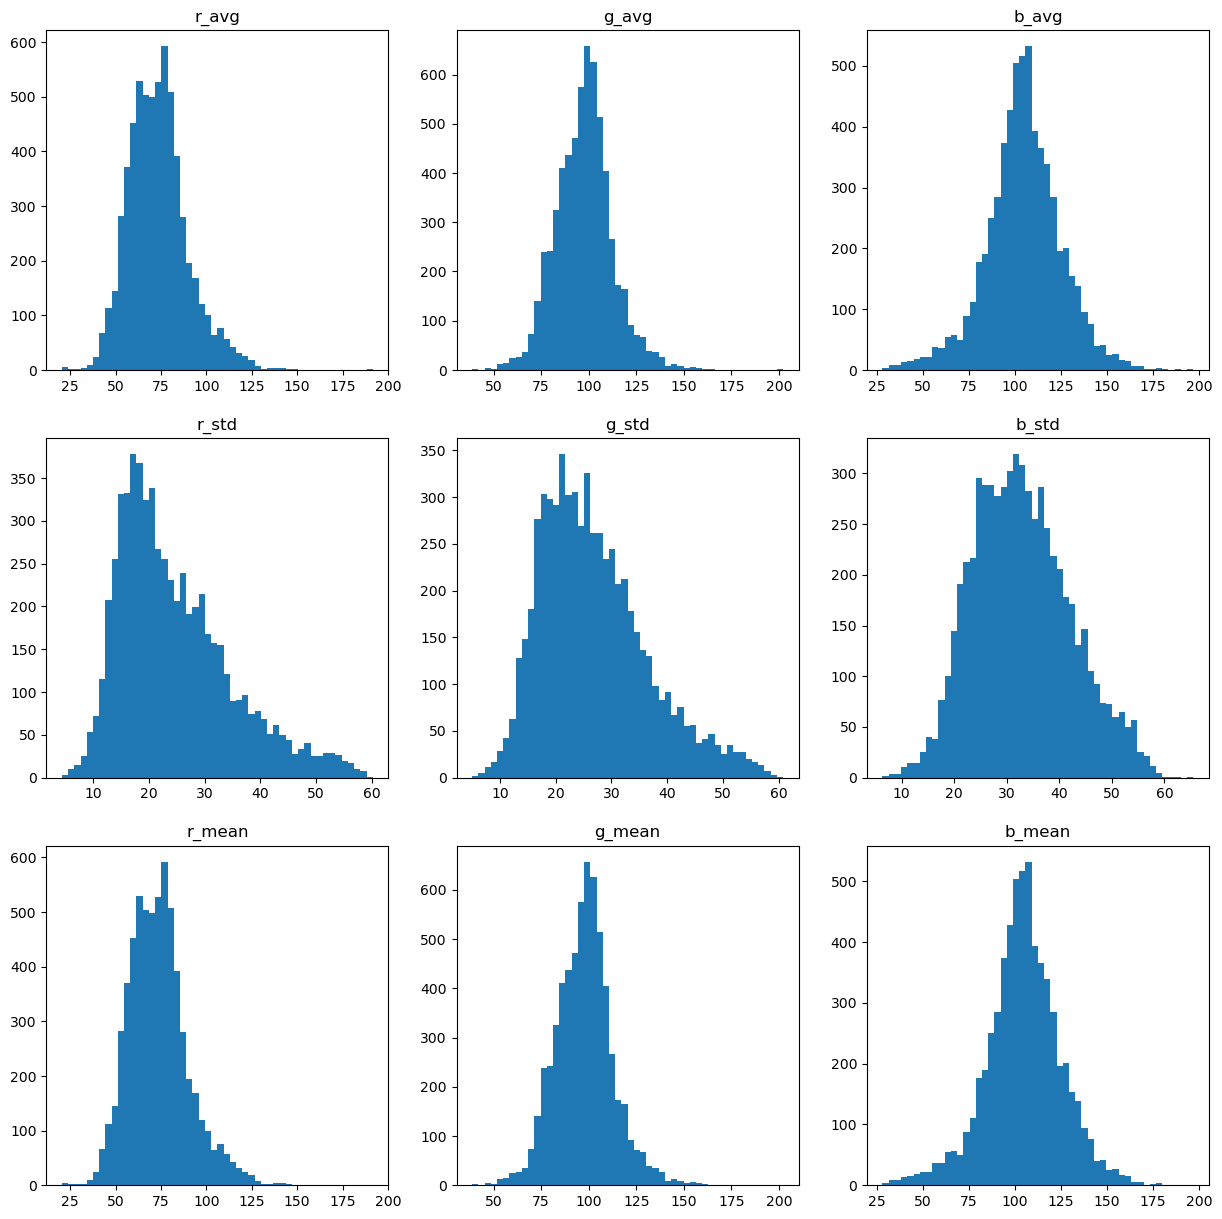

In [29]:
# draw rgb values on plots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, column in enumerate(rgb_pd.columns):
    axs[i // 3, i % 3].hist(rgb_pd[column], bins=50)
    axs[i // 3, i % 3].title.set_text(column)
plt.show()